In [1]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
from torchsummary import summary
import numpy as np
import pandas as pd
import random
import glob, os, sys
import sys
from PIL import Image
import cv2
from timeit import default_timer as timer
from tqdm import tqdm
import seaborn as sns
from imutils import paths
from utils import *
import matplotlib.pyplot as plt
import warnings
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
# sns.set_theme(style="darkgrid")

In [2]:
args = {
    'dataTest': 'Covid19\\test',
    'weights': 'weights\\inference.pt',
}

weight_name = args['weights'].split('\\')[-1]
print(f'[INFO] loading weight: {weight_name}')

if cuda.is_available():
    load_Torch = 'cuda:'+str(torch.cuda.current_device())
else:
    load_Torch = 'cpu'

model = torch.load(args['weights'], map_location=load_Torch)  # map_location could be remove in presence of GPU
model.eval()

print(f'[INFO] GPU: {torch.cuda.get_device_name(load_Torch)}')

[INFO] loading weight: inference.pt
[INFO] GPU: GeForce RTX 2070


In [3]:
imagePaths = list(paths.list_images(args['dataTest']))
totalImages = len(imagePaths)
groundTruth = []
predictions = []
imagesList = []

for (i, imagePath) in enumerate(imagePaths):
    
    disease = imagePath.split(os.path.sep)[-2]  # disease name
    imageName = imagePath.split(os.path.sep)[-1]  # image name
    imageLoc = disease+'\\'+imageName  # to append
    
    ready = round(100 * (i+1) / totalImages, 1)
    sys.stdout.write(f'\r[INFO] {disease} | {format(ready)}% ready | {format((i+1))} images')
    
    # actual prediction
    predict, winner = display_prediction2(imagePath, model, disease, topk=3, save=False, show=False)  # disease = real label
    
    # for Pandas DF
    groundTruth.append(disease)
    predictions.append(winner)
    imagesList.append(imageLoc)

    cv2.waitKey(20)
    sys.stdout.flush()

[INFO] Pneumonia | 100.0% ready | 66 images

In [4]:
data = {
    'True-Label': groundTruth,
    'Predicted-Label': predictions,
    'Image-Location': imagesList
}

df = pd.DataFrame(data, columns=['True-Label', 'Predicted-Label', 'Image-Location'])

In [5]:
df.describe(include='all')

,True-Label,Predicted-Label,Image-Location
count,66,66,66
unique,3,3,66
top,Covid,Covid,Pneumonia\0108.jpeg
freq,26,24,1


In [6]:
df['True-Label'].value_counts()

Covid        26
Pneumonia    20
Normal       20
Name: True-Label, dtype: int64

In [7]:
df['Predicted-Label'].value_counts()

Covid        24
Pneumonia    22
Normal       20
Name: Predicted-Label, dtype: int64

In [8]:
df['Comparison'] = (df['True-Label'] == (df['Predicted-Label']))

In [9]:
df.head(10)

,True-Label,Predicted-Label,Image-Location,Comparison
0,Covid,Normal,Covid\0100.jpeg,False
1,Covid,Covid,Covid\0102.jpeg,True
2,Covid,Covid,Covid\0105.jpg,True
3,Covid,Normal,Covid\0106.jpeg,False
4,Covid,Covid,Covid\0108.jpeg,True
5,Covid,Covid,Covid\0111.jpg,True
6,Covid,Covid,Covid\0112.jpg,True
7,Covid,Covid,Covid\0113.jpg,True
8,Covid,Covid,Covid\0115.jpeg,True
9,Covid,Covid,Covid\0118.jpeg,True


In [10]:
df.shape[0]

66

In [16]:
err = 0
errList = []

for i, boolean in df['Comparison'].iteritems():
    if boolean == False:
        errList.append(df['Image-Location'][i])
        err += 1
        
print(f'There are {round(100*4/df.shape[0], 2)}% with a wrong clasification')
print(errList)

There are 6.06% with a wrong clasification
['Covid\\0100.jpeg', 'Covid\\0106.jpeg', 'Normal\\0105.jpeg', 'Normal\\0119.jpeg']


[INFO] image: Covid19\test\Covid\0100.jpeg
                  p
Normal     0.695897
Covid      0.179071
Pneumonia  0.125032


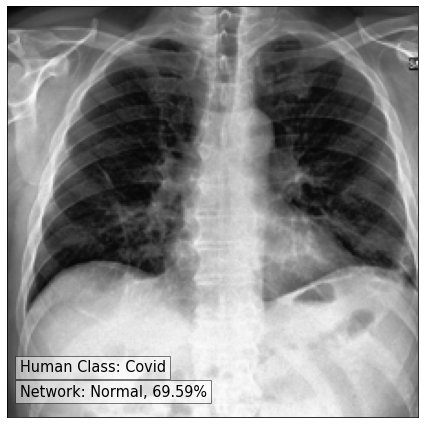

[INFO] The neural network has misclassified the image: Covid\0100.jpeg


In [23]:
id = 0  # id of the vector errList with the wrong classified images

real_label = errList[id].split(os.path.sep)[0]  # disease name
full_address = os.path.join(args['dataTest'], errList[id])  # location to the image for inference

ok_prediction, winner = display_prediction2(full_address, model, real_label, save=False, show=True)

if ok_prediction:
    print(f'[INFO] The neural network has classified correctly the image: {errList[id]}')
else:
    print(f'[INFO] The neural network has misclassified the image: {errList[id]}')